Got the right star this time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)


massA = 0.846
teffA = 5407
teff_eA = 52
radiusA = 0.8310

massB = 0.698
teffB = 4393
teff_eB = 149
radiusB = 0.6697

distance = 5.113

save_path = 'models/'
# star = 'toi-134'
gA = ((G*massA*M)/(radiusA*R)**2).to(u.cm/u.s**2)
gB = ((G*massB*M)/(radiusB*R)**2).to(u.cm/u.s**2)
# print(gA, gB)
# g = 4.04
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

A_star_params = {'Teff': teffA, 'Teff_e':teff_eA,  'logg': np.log10(gA.value), 'FeH': 0.00, 'aM': 0, 'Radius':radiusA*u.R_sun, 'Distance':distance*u.pc}
# pwA, pfA, peA = pp.make_phoenix_spectrum('70_oph_A', save_path, repo, A_star_params, save_ecsv=True, plot=True, make_error=True)
pdataA = Table.read('models/{}_phoenix_interpolated.ecsv'.format('70_oph_A'))
pwA, pfA, peA = pdataA['WAVELENGTH'], pdataA['FLUX'], pdataA['ERROR']
normfacA = ((radiusA*R)/((distance*u.pc).to(u.m)))**2

B_star_params = {'Teff': teffB, 'Teff_e':teff_eB,  'logg': np.log10(gB.value), 'FeH': 0.00, 'aM': 0, 'Radius':radiusB*u.R_sun, 'Distance':distance*u.pc}
# pwB, pfB, peB = pp.make_phoenix_spectrum('70_oph_B', save_path, repo, B_star_params, save_ecsv=True, plot=True, make_error=True)
pdataB = Table.read('models/{}_phoenix_interpolated.ecsv'.format('70_oph_B'))
pwB, pfB, peB = pdataB['WAVELENGTH'], pdataB['FLUX'], pdataB['ERROR']
normfacB = ((radiusB*R)/((distance*u.pc).to(u.m)))**2

pw, pf, pe= pwB, pfB, peB
normfac = normfacB

Only COS FUV data. Have a look, then make a clean spectrum for ETC for a STIS proposal.

In [3]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/complete_spectra/cos/complete_spectra/'

In [4]:
cspecs = glob.glob('{}*cspec.fits'.format(path))
cspecs

[]

In [5]:
for x in cspecs:
    print(x)
    # print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)[0]
    # print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    # mask = w > 1160
    # w, f, e = w[mask], f[mask], e[mask]
    fig, ax = plt.subplots()
    ax.step(w, f, where='mid', c='C0')
    ax.step(w, e, where='mid', c='C1', alpha=0.5)



all pretty good, use one for an etc input

In [6]:
# etc = Table([w, f], names=['#WAVELENGTH', 'FLUX'])
# etc.write('etc_input/70oph_B_cos.dat', format='ascii.basic', overwrite=True)

We used the spectrum from PID 16003 for the DEM, have to reproduce that

In [9]:
cospath = '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/'
x1ds = glob.glob('{}*x1dsum.fits'.format(cospath))
x1ds

['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11010_x1dsum.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11020_x1dsum.fits']

G130M le5s11vzq
G160M le5s11w7q


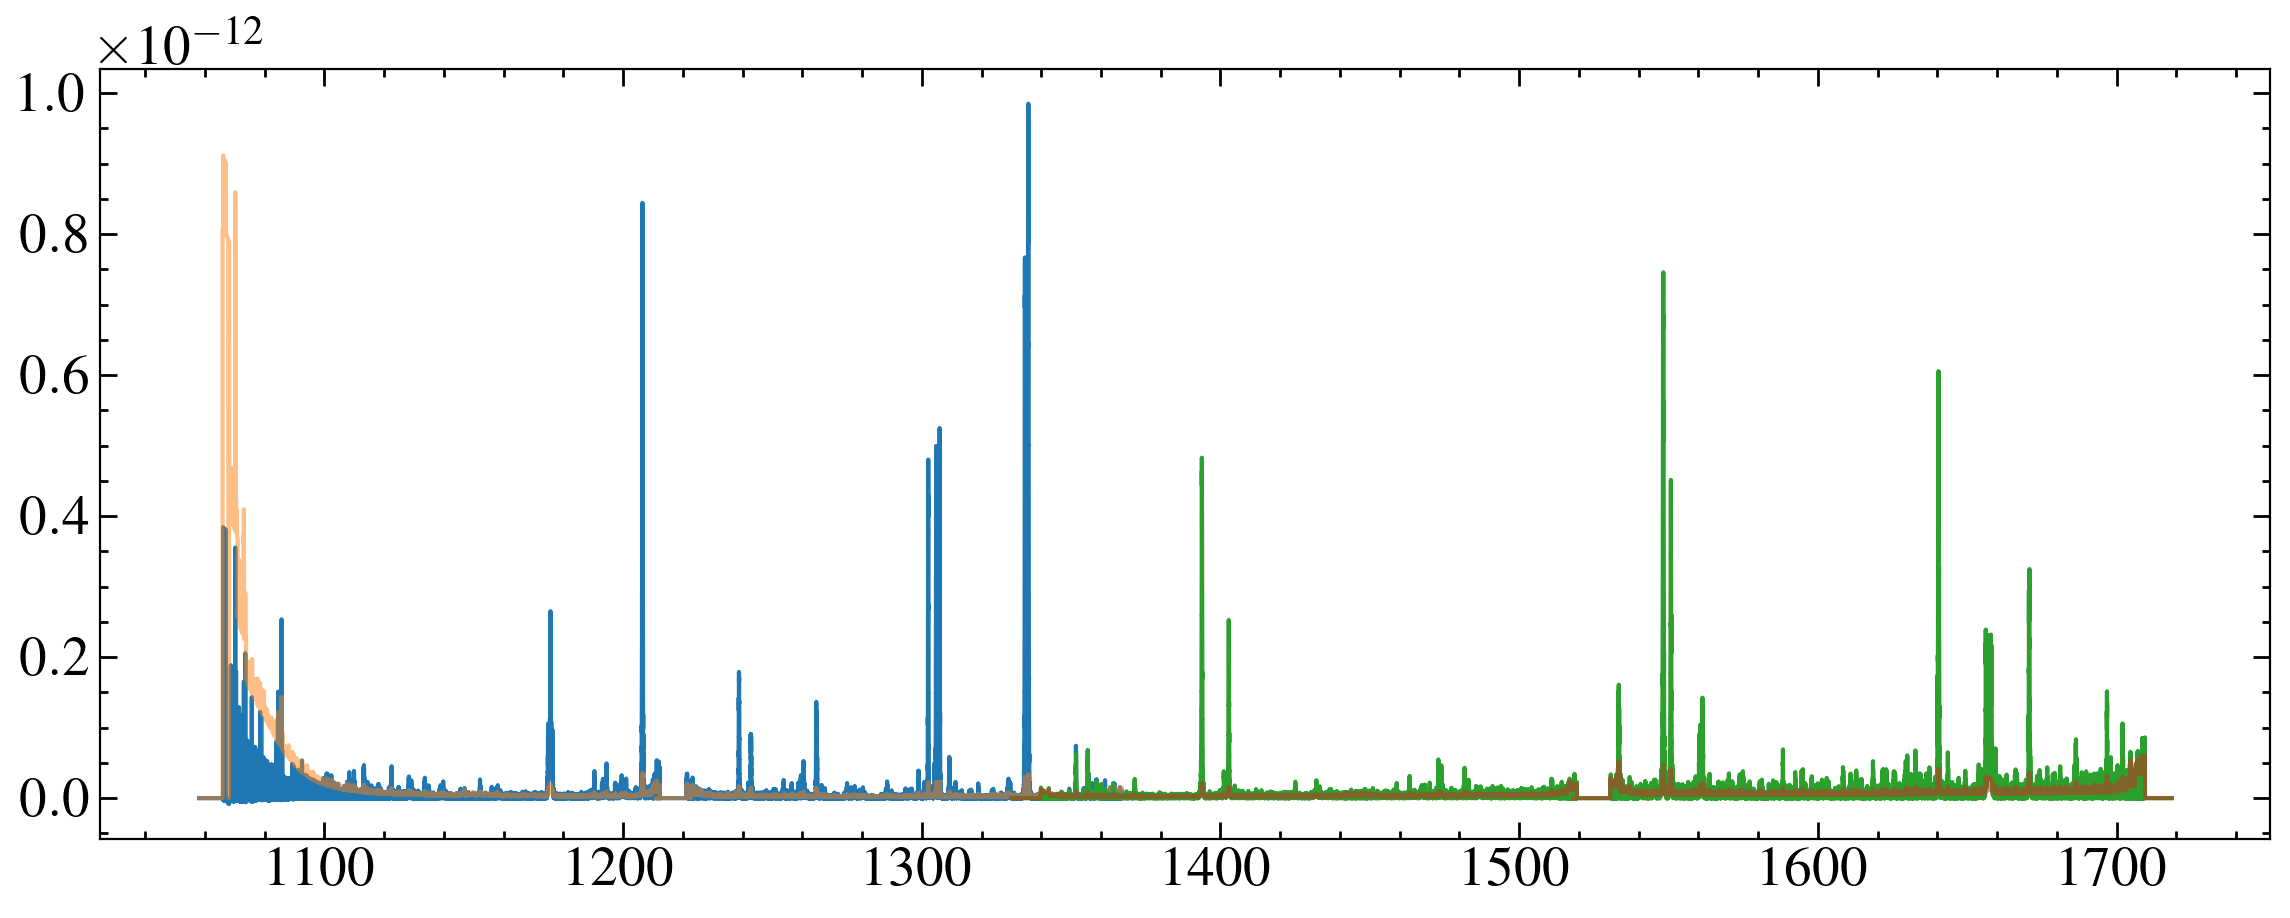

In [38]:
fig, ax = plt.subplots()
for x in x1ds:
    data = fits.getdata(x, 1)[::-1]
    hdr = fits.getheader(x, 0)
    grating = hdr['OPT_ELEM']
    rootname= hdr['ROOTNAME']
    print(grating, rootname)
    w, f, e = np.hstack(data['WAVELENGTH']), np.hstack(data['FLUX']), np.hstack(data['ERROR'])
    ax.step(w, f, where='mid')
    ax.step(w, e, where='mid', alpha=0.5)
    args = np.argsort(w)
    w, f ,e = w[args], f[args], e[args]
    savdat = Table([w, f, e], names = ['WAVELENGTH', 'FLUX', 'ERROR'])
    savdat.write('cos_files/70_oph_b/{}_{}_simple.txt'.format(rootname, grating), format='ascii.basic', overwrite=True)
    # ax.plot(w[:-1], np.diff(w))

cos_files/70_oph_b/le5s11vzq_G130M_simple.txt
['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/g130m/le5s11010_x1dsum.fits']
['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/g130m/le5s11010_x1dsum.fits']


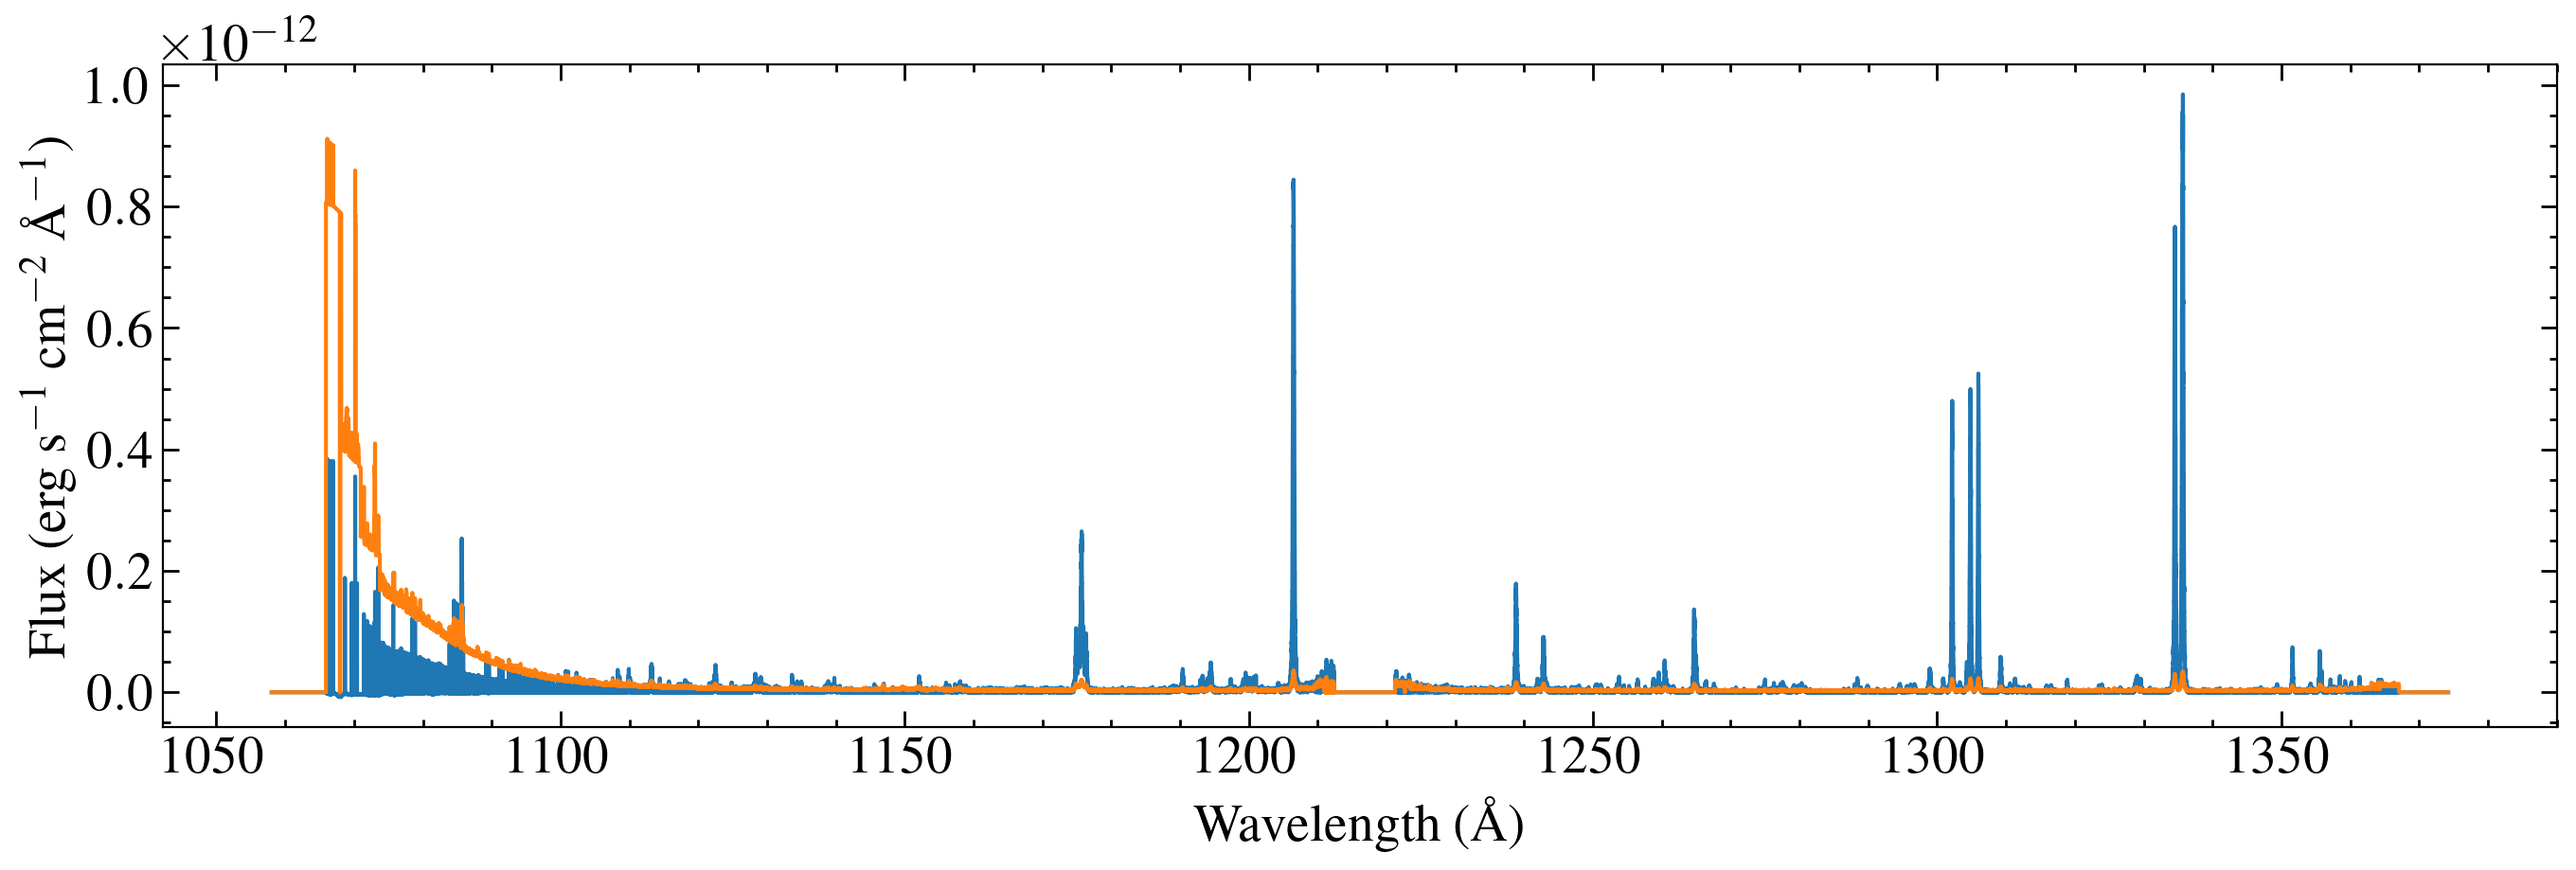

Spectrum saved as hlsp_muscles_hst_cos_70_oph_b_g130m_v1_component-spec.fits
cos_files/70_oph_b/le5s11w7q_G160M_simple.txt
['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/g160m/le5s11020_x1dsum.fits']
['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/g160m/le5s11020_x1dsum.fits']


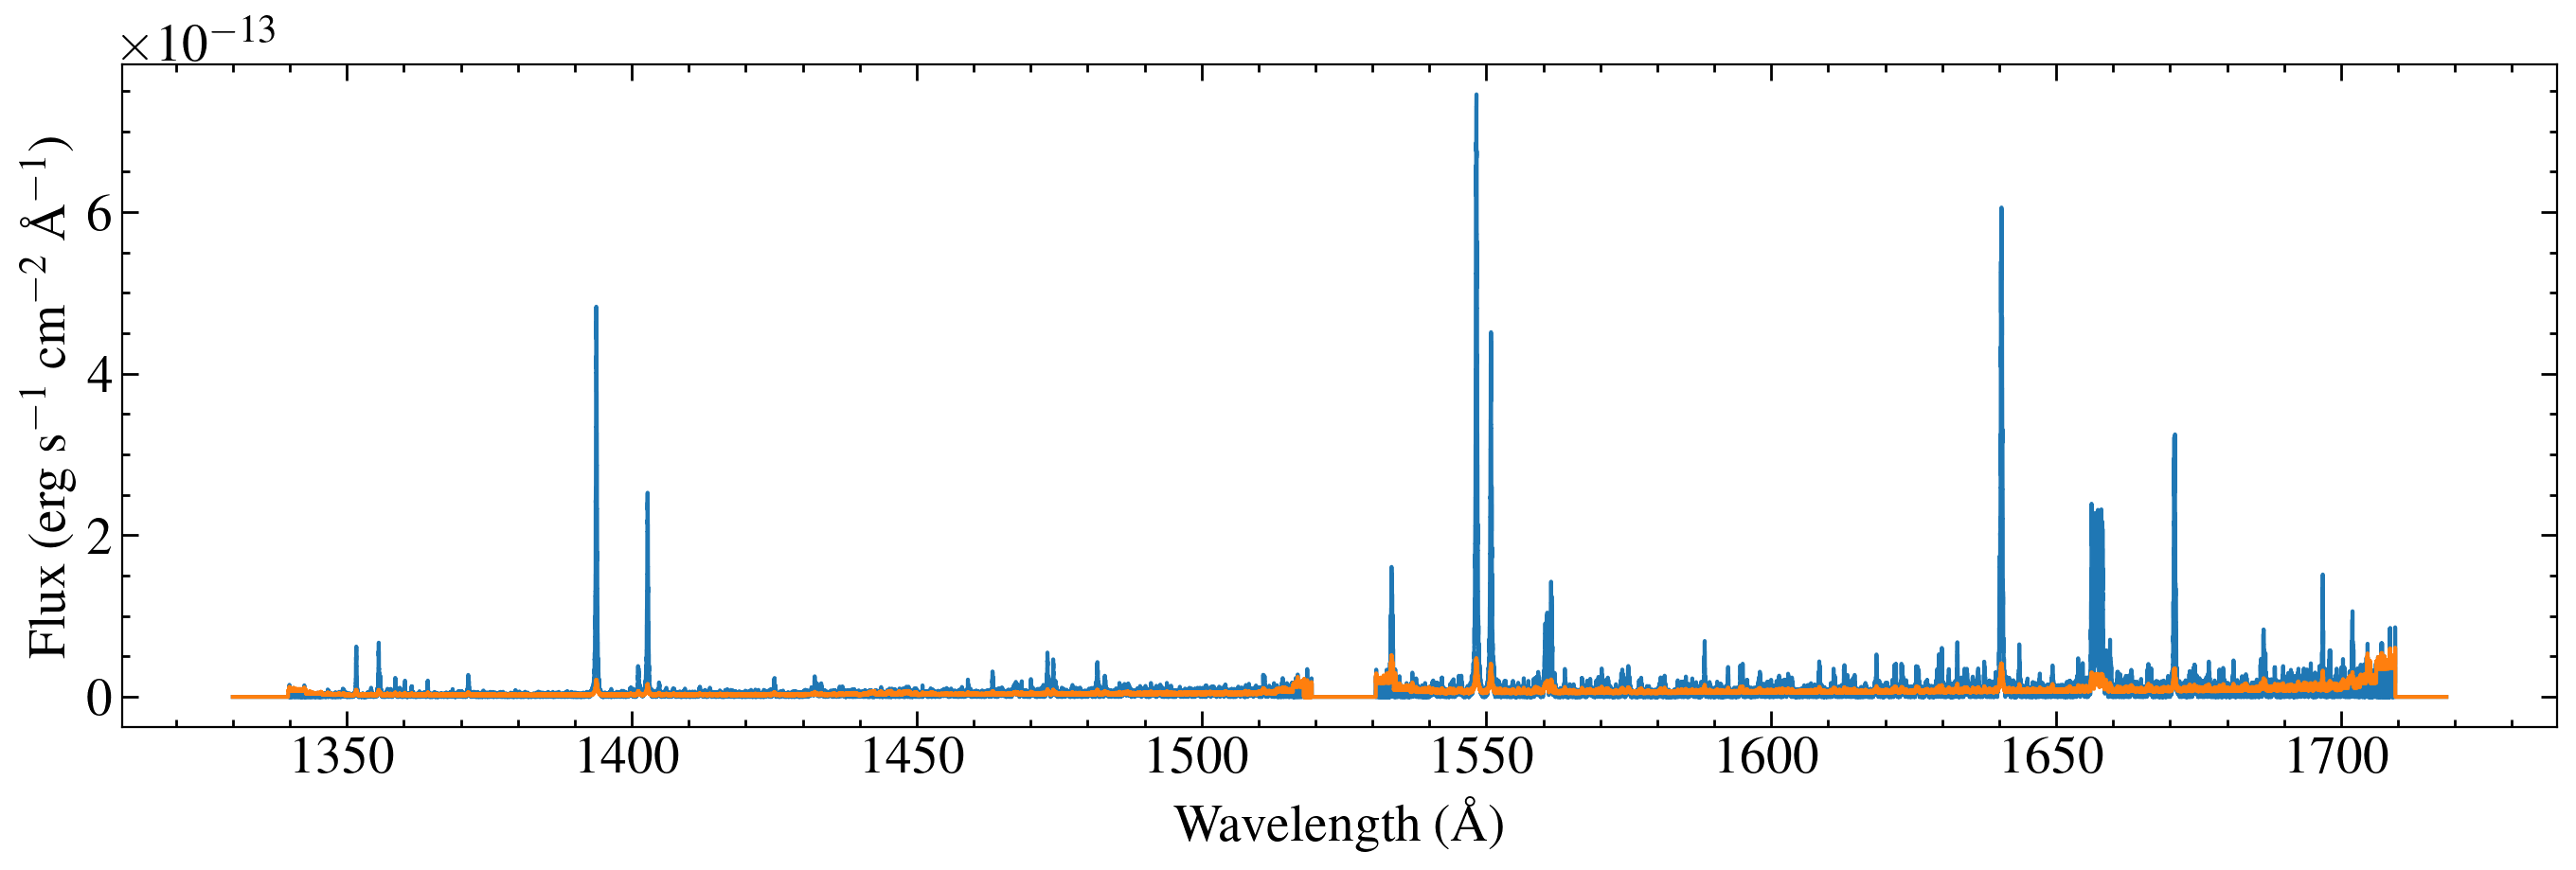

Spectrum saved as hlsp_muscles_hst_cos_70_oph_b_g160m_v1_component-spec.fits


In [49]:
import importlib
import prepare_cos
importlib.reload(prepare_cos)

savpath = glob.glob('cos_files/70_oph_b/*')
hlsp = 'meats_hlsp_info.csv'
version = 1
savepath = 'draft_hlsp/70_Oph_B/'
# star =
gratings = ['g130m', 'g160m']
for i, sav in enumerate(savpath):
    
    print(sav)
    prepare_cos.make_cos_spectrum(sav, version, '{}{}/'.format(cospath, gratings[i]), hlsp, savepath = savepath, plot=True, save_fits=True, star='70_Oph_B')

I think there's a bug in prepare COS when it comes to chooseing the x1d files. Not worth fixing, do in the great hasp upgrade. Ok it doesn't like it at all. Think that worked.

In [46]:
import prepare_model
hdr = fits.getheader('draft_hlsp/70_Oph_B/hlsp_muscles_hst_cos_70_oph_b_g160m_v1_component-spec.fits', 0)
sed_data = Table(meta=hdr)
#PHX
prepare_model.make_model_spectrum('models/70_oph_B_phoenix_interpolated.ecsv', 1, sed_data,
                                  savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')


Spectrum saved as hlsp_muscles_model_phx_70_oph_b_na_v1_component-spec.fits


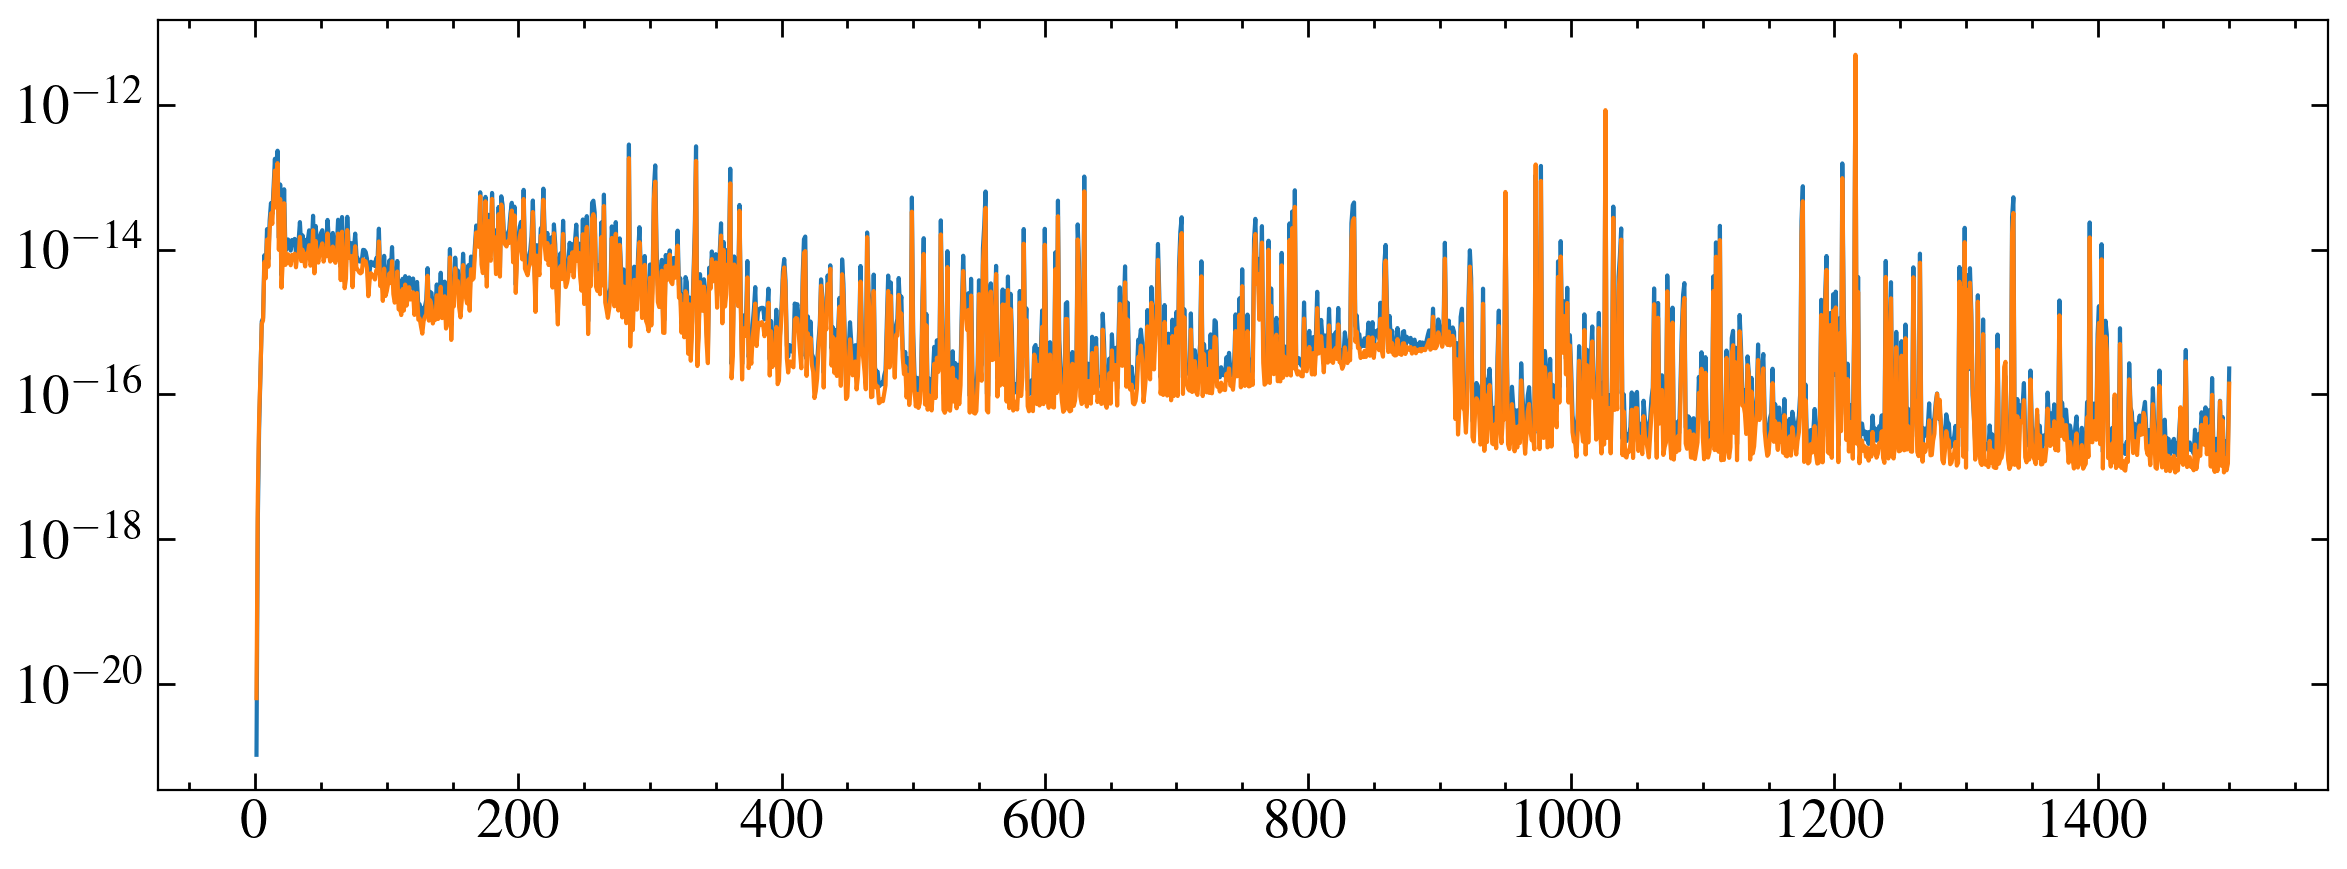

In [55]:
#dem 
dempath = '/media/david/2tb_ext_hd/hddata/meats/dems/70_oph_B/spectrum_70_oph_B_p17.fits'
dem = fits.getdata(dempath, 1)

dw, df= dem['Wavelength'], dem['Flux_density']
eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']


mean_e = np.mean([eu, el], axis=0)
# plt.plot(dw, mean_e)
# plt.yscale('log')

log_mean_e = (eu - el) / (np.log(eu)- np.log(el))

plt.plot(dw, df)
plt.plot(dw, log_mean_e)
# plt.plot(dw, df/log_mean_e)
# plt.plot(dw, mean_e)

plt.yscale('log')

demtab = Table([dw, df, log_mean_e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
demtab.write('models/70ophB_dem.ecsv', overwrite=True)



In [56]:
#dem
prepare_model.make_model_spectrum('models/70ophB_dem.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='dem')

Spectrum saved as hlsp_muscles_model_dem_70_oph_b_na_v1_component-spec.fits


X-ray spectrum is a Chandra grating spectrum, don't know if I have anything coded up for that.

In [93]:
xspec = Table.read('/media/david/2tb_ext_hd/hddata/meats/chandra/70_oph/prt70bspec.txt', format='ascii.basic')
xspec

WAVELENGTH,COUNTS,FLUX
float64,float64,float64
1.00625,-1.0,-0.010134198
1.01875,5.16667,0.052360022
1.03125,-0.966667,-0.0097963912
1.04375,-0.0333333,-0.00033780627
1.05625,-2.0,-0.020268396
1.06875,-4.0,-0.040536793
1.08125,-0.3,-0.0030402612
1.09375,0.766666,0.0077695493
1.10625,1.86667,0.018917165


16384 0.012500000000002842
5767


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_123346/3649323719.py:20: RuntimeWarning: invalid value encountered in sqrt
  counts_e = c**0.5


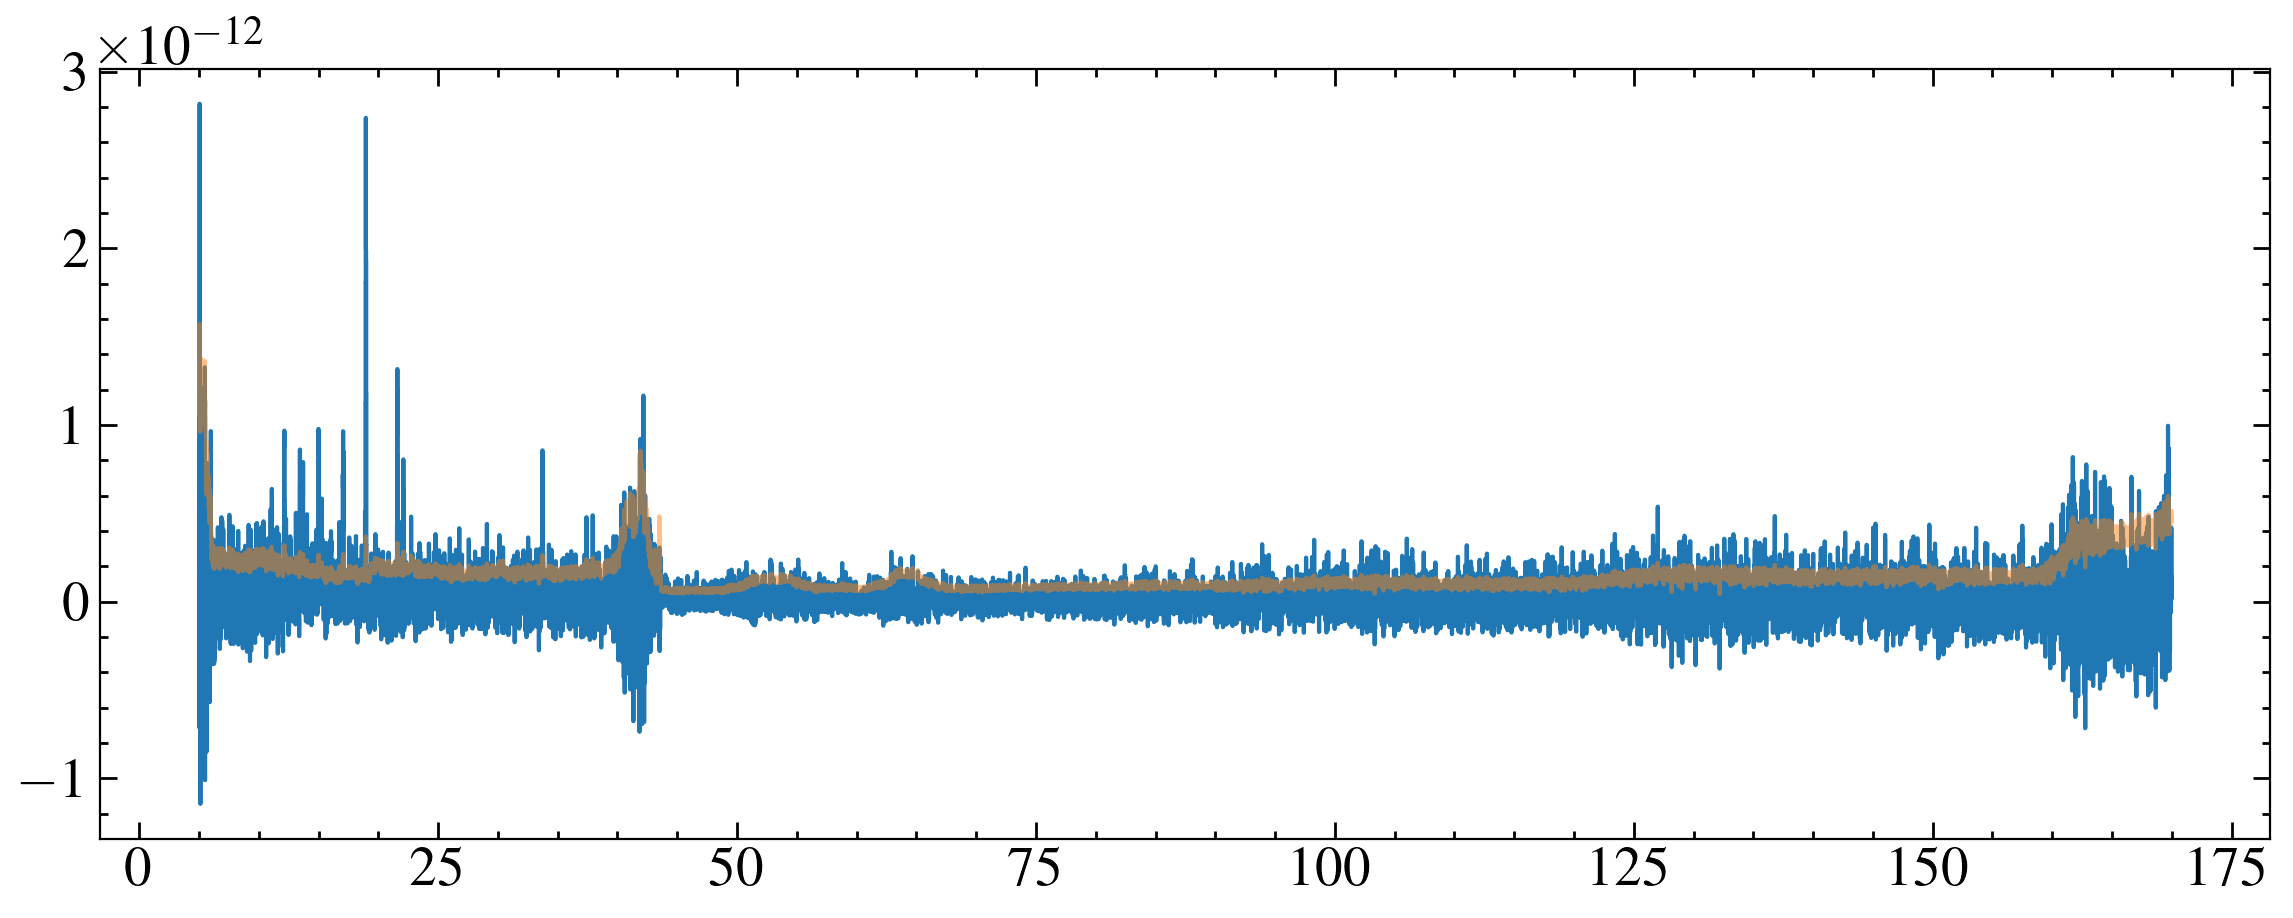

In [154]:
from  astropy.stats import poisson_conf_interval as conf

fig, ax = plt.subplots()

# ax.step(xspec['WAVELENGTH'], xspec['FLUX'])
print(len(xspec['WAVELENGTH']), np.median(np.diff(xspec['WAVELENGTH'])))


w, c, f = xspec['WAVELENGTH'], xspec['COUNTS'], xspec['FLUX']
mask = (w >= 5) & (w <=170)
w, c, f = w[mask].value, c[mask].value, f[mask].value

f = (f * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(w*u.AA))

sense = f/c
# print(sense)


print(len(c[c < 0.0]))
counts_e = c**0.5
e = counts_e *sense

bkg_est = abs(min(c))
e_adj = sense *(c + bkg_est)**0.5 
# print('nans', len(c[np.isnan(c)]))

# print('nans', len(e[np.isnan(e)]))
# print('nans', len(e_adj[np.isnan(e_adj)]))

c_p = conf((c+bkg_est), interval='pearson')
c_p = abs(c_p - (c+bkg_est))
c_p = np.max(c_p, axis=0)
e_p = c_p * sense

# c_p = c-conf[0]
# print('nans', len(c_p[0][np.isnan(c_p)[0]]))

# print(c_p)

ax.step(w, f, where='mid')
# ax.step(w, e, alpha=0.5, where='mid')
# ax.step(w, e_adj, alpha=0.5, where='mid')
ax.step(w, e_p, alpha=0.5, where='mid')
# ax.step(w, e/e_p, alpha=0.5, where='mid')
# ax.step(w, ((c+bkg_est)-c_p[0])/(c_p[1]-(c+bkg_est)))
# ax.step(w, c_p[0])
# ax.step(w, c_p[1])
# ax.step(w, c+bkg_est)
# ax.step(w, c_p)

# print(np.median(c), np.mean(c), np.std(c))
# print(min(c), min(c)/np.std(c))
# fig, ax = plt.subplots()
# ax.step(w, c, where='mid')

xf, xw, xe = w, f, e_p

In [78]:
# plt.hist(c, bins=100, range = (-5, 5))

Bin to what it says in paper - assume lowest point is bg subtraction (see how that changes over spectum) - recaclulate errors.  

Paper runs 5-175A, rebins by factor 3. I wont rebin as standard practice to put OG spectrum in, and the spectrum is sigficant enough

In [155]:
savdat = Table([w, f, e_p], names =['WAVELENGTH', 'FLUX', 'ERROR'])
savdat.write('/media/david/2tb_ext_hd/hddata/meats/chandra/70_oph/70ophB_xray_spec.txt', format='ascii.basic', overwrite=True)

In [143]:
print(w[0], w[-1]) #not backwards

5.00625 169.99375


In [156]:
import prepare_chandra
importlib.reload(prepare_chandra)


hlsp = Table.read('meats_hlsp_info.csv')

prepare_chandra.make_chandra_spectra('/media/david/2tb_ext_hd/hddata/meats/chandra/70_oph/70ophB_xray_spec.txt', '/media/david/2tb_ext_hd/hddata/meats/chandra/70_oph/22663/primary/hrcf22663N003_evt2.fits.gz', savepath, 1, hlsp, make_apec=False, save_ecsv=False, save_fits=True, grating =True, star='70_Oph_B')

Spectrum saved as hlsp_muscles_cxo_hrc_70_oph_b_none_v1_component-spec.fits


In [158]:
hlsp = glob.glob('draft_hlsp/70_Oph_B/*.fits')
hlsp

['draft_hlsp/70_Oph_B/hlsp_muscles_hst_cos_70_oph_b_g130m_v1_component-spec.fits',
 'draft_hlsp/70_Oph_B/hlsp_muscles_hst_cos_70_oph_b_g160m_v1_component-spec.fits',
 'draft_hlsp/70_Oph_B/hlsp_muscles_model_dem_70_oph_b_na_v1_component-spec.fits',
 'draft_hlsp/70_Oph_B/hlsp_muscles_model_phx_70_oph_b_na_v1_component-spec.fits',
 'draft_hlsp/70_Oph_B/hlsp_muscles_cxo_hrc_70_oph_b_none_v1_component-spec.fits']

draft_hlsp/70_Oph_B/hlsp_muscles_hst_cos_70_oph_b_g130m_v1_component-spec.fits
1058.033135302097 1374.240608359525
draft_hlsp/70_Oph_B/hlsp_muscles_hst_cos_70_oph_b_g160m_v1_component-spec.fits
1329.9742944843244 1718.493248365018
draft_hlsp/70_Oph_B/hlsp_muscles_model_dem_70_oph_b_na_v1_component-spec.fits
1.0 1500.0
draft_hlsp/70_Oph_B/hlsp_muscles_cxo_hrc_70_oph_b_none_v1_component-spec.fits
5.00625 169.99375


(1e-17, 1e-10)

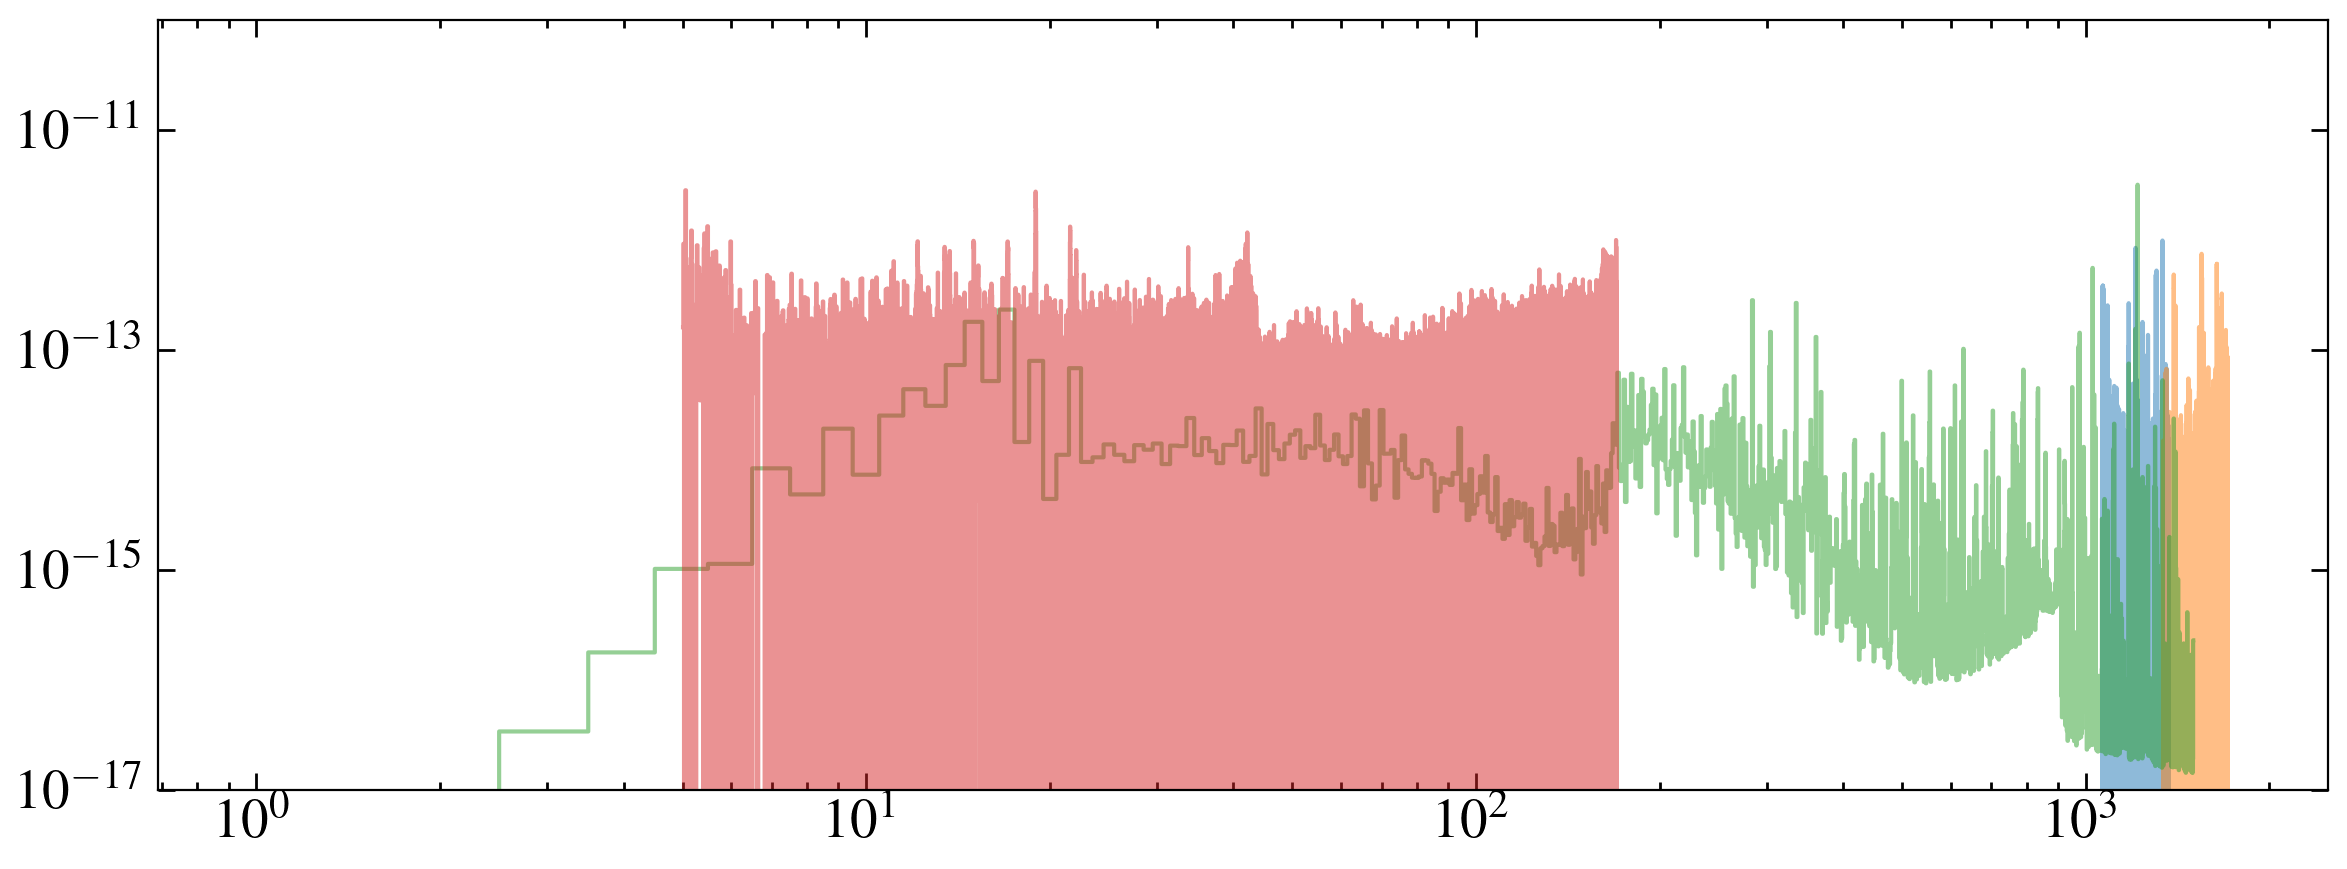

In [167]:
fig, ax = plt.subplots()

for spec in hlsp:

    if 'phx' not in spec:
        print(spec)
        data = fits.getdata(spec, 1)
        hdr = fits.getheader(spec, 0)
        ax.step(data['WAVELENGTH'], data['FLUX']*hdr['NORMFAC'], where='mid', alpha=0.5)
        print(data['WAVELENGTH'][0], data['WAVELENGTH'][-1])

ax.set_yscale('log')

ax.set_xscale('log')

ax.set_ylim(1e-17, 1e-10)
# ax.set_xlim(5, 1e5)

Ok 70 Oph B done as far as we can, now for the other half of the FrankenSpecktrum